# Baseline Model – ElasticNet for Short-Range Wind Power Forecasting

To establish a solid baseline for semi-supervised wind power forecasting, I evaluated **ElasticNet regression** across varying levels of labeled data availability. The model was trained and validated using subsets of the dataset corresponding to **1%, 5%, 10%, 20%, and 100%** of the available labeled data.

**Although the overall task targets semi-supervised regression, evaluating fully supervised models like ElasticNet (and later, XGBoost) remains essential for two key reasons:**

1. **Performance Reference:** Supervised models trained on labeled data provide a lower-bound (and in some cases, upper-bound) reference for prediction quality. This allows quantifying the **added value of incorporating unlabeled data** in semi-supervised methods like S2RMS.

2. **Data Efficiency Benchmarking:** By observing how predictive performance degrades with fewer labeled samples, supervised models help assess **data efficiency**. If a semi-supervised model achieves comparable accuracy with significantly less labeled data, it validates the advantage of leveraging unlabeled instances.

Key steps:

* The dataset was temporally sorted and split using a **time-based split**, with the final 10% reserved as the test set to mimic real-world forecasting conditions.
* A **GridSearchCV** was used to optimize the regularization parameters `alpha` and `l1_ratio` for each run.
* The model pipeline included **feature standardization** and was evaluated using **MAE, RMSE, and R²** metrics.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [56]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.2, 1.0]
RANDOM_STATE = 42

## 1. Load and Prepare Dataset

In [57]:
df = pd.read_csv("../data/processed/wtb_features.csv")

# Sort by time for proper temporal split
df = df.sort_values("Timestamp")

In [58]:
target = 'Patv'
drop_cols = ['Patv', 'Timestamp', 'TurbID']
X = df.drop(columns=drop_cols)
y = df[target]

In [59]:
results = {}

## 2. ElasticNet + GridSearchCV

In [60]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=10000))
])

In [61]:
param_grid = {
    'elasticnet__alpha': [0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
}

In [ ]:
for pct in PERCENTAGES:
    print(f"\n--- Training with {int(pct * 100)}% of labeled data ---")

    if pct < 1.0:
        X_train_full, _, y_train_full, _ = train_test_split(X, y, train_size=pct, shuffle=False)
    else:
        X_train_full = X.copy()
        y_train_full = y.copy()

    # Use last 10% of original data as test set
    split_idx = int(len(X) * 0.9)
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]

    # Grid Search on training set
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_full, y_train_full)

    y_pred = grid_search.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best Params: {grid_search.best_params_}")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}")

    label = f"{int(pct * 100)}%"
    results[label] = {
        'best_params': grid_search.best_params_,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    }

    joblib.dump(grid_search.best_estimator_, f"../models/elasticnet_{label}.joblib")


--- Training with 1% of labeled data ---
Best Params: {'elasticnet__alpha': 10.0, 'elasticnet__l1_ratio': 0.9}
MAE: 249.37 | RMSE: 309.81 | R^2: 0.339

--- Training with 5% of labeled data ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 135.47 | RMSE: 165.12 | R^2: 0.812

--- Training with 10% of labeled data ---
Best Params: {'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.9}
MAE: 175.21 | RMSE: 201.31 | R^2: 0.721

--- Training with 20% of labeled data ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 132.59 | RMSE: 162.14 | R^2: 0.819

--- Training with 100% of labeled data ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 100.82 | RMSE: 136.86 | R^2: 0.871


In [63]:
with open("../results/elasticnet_semisupervised_scores.json", "w") as f:
    json.dump(results, f, indent=4)

## 3. Model Evaluation

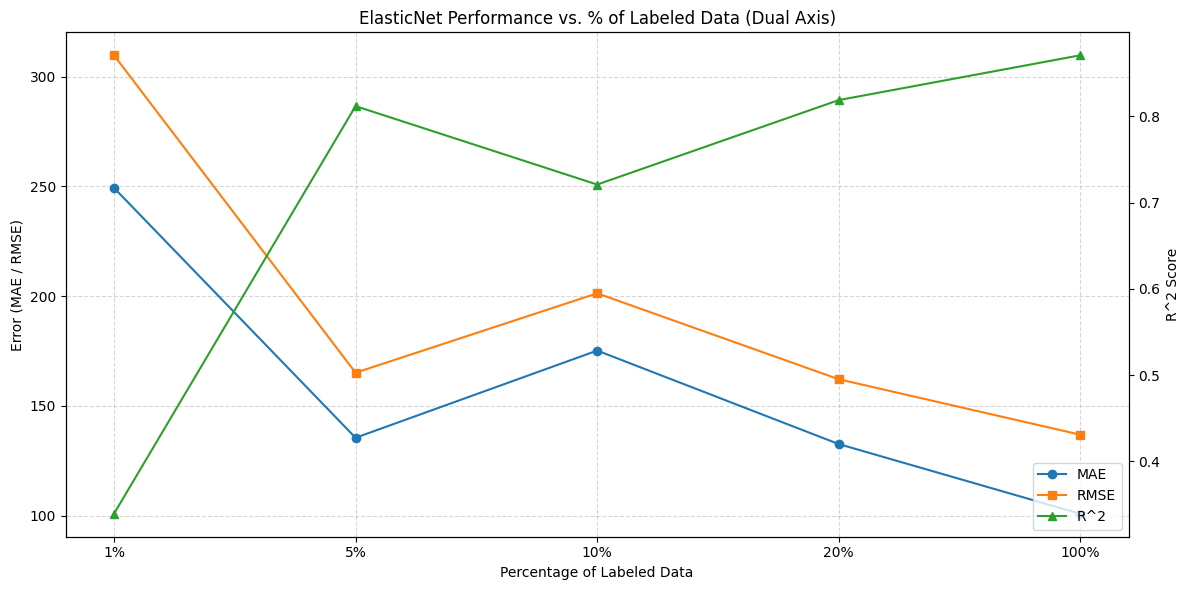

In [64]:
labels = list(results.keys())

maes = [results[k]['MAE'] for k in labels]
rmses = [results[k]['RMSE'] for k in labels]
r2s = [results[k]['R2'] for k in labels]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Percentage of Labeled Data")
ax1.set_ylabel("Error (MAE / RMSE)")
ax1.plot(labels, maes, marker='o', linestyle='-', label="MAE", color='tab:blue')
ax1.plot(labels, rmses, marker='s', linestyle='-', label="RMSE", color='tab:orange')
ax1.tick_params(axis='y')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel("R^2 Score")
ax2.plot(labels, r2s, marker='^', linestyle='-', label="R^2", color='tab:green')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title("ElasticNet Performance vs. % of Labeled Data (Dual Axis)")
plt.tight_layout()
plt.show()


#### Results:

| % Labeled | MAE    | RMSE   | R^2    | Best Params           |
| --------- | ------ | ------ | ----- | --------------------- |
| 1%        | 249.37 | 309.81 | 0.339 | α=10.0, l1\_ratio=0.9 |
| 5%        | 135.47 | 165.12 | 0.812 | α=0.1, l1\_ratio=0.9  |
| 10%       | 175.21 | 201.31 | 0.721 | α=1.0, l1\_ratio=0.9  |
| 20%       | 132.59 | 162.14 | 0.819 | α=0.1, l1\_ratio=0.9  |
| 100%      | 100.82 | 136.86 | 0.871 | α=0.1, l1\_ratio=0.9  |

#### Observations:

* The performance improves significantly from 1% to 5%, indicating that even a small labeled subset carries substantial predictive signal.
* R^2 reaches **0.81 with only 5%** of the data, and further improves modestly with additional labeled data.
* The model consistently prefers **high L1 regularization (l1\_ratio=0.9)**, suggesting that sparsity helps generalize under low-label scenarios.

This baseline will be used as a reference to compare with **semi-supervised models** (e.g., S2RMS), which aim to further improve performance by leveraging unlabeled data.

We now inspect the model coefficients to better understand which features were most influential in this prediction task.

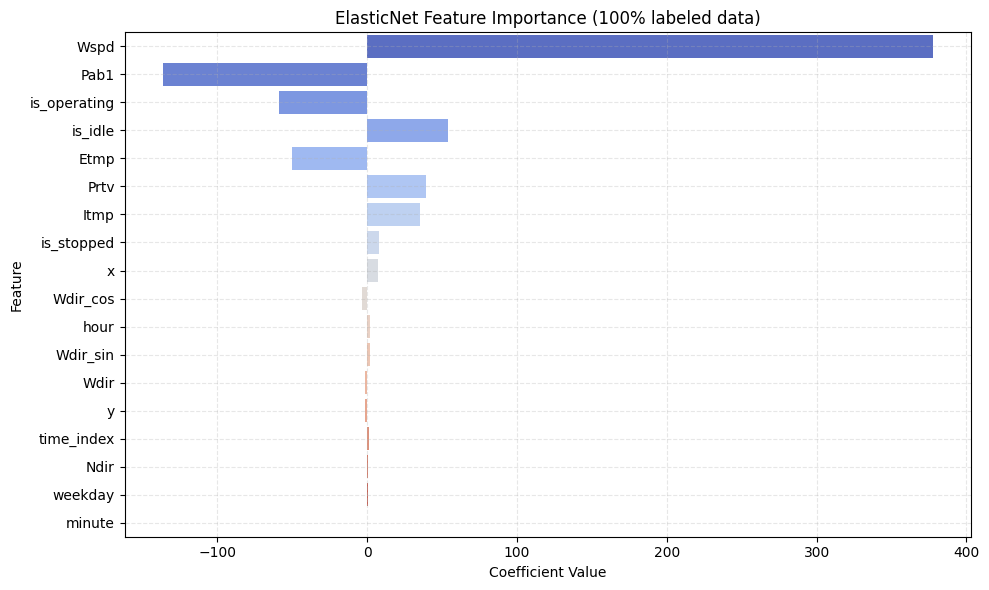

In [67]:
model_100 = joblib.load("../models/elasticnet_100%.joblib")

best_model = model_100.named_steps['elasticnet']

feature_names = X.columns
coefs = best_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df,
    hue='Feature',
    palette='coolwarm',
    dodge=False,
    legend=False
)

plt.title("ElasticNet Feature Importance (100% labeled data)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
